In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


In [4]:
f=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/background_for_training.h5','r')
Dataset=np.array(f["Particles"])

Data_Train=Dataset[0:2000000,:,0:3]
Data_Test=Dataset[2000001:3600000,:,0:3]
Data_Validate=Dataset[3600001:4000000,:,0:3]

Data_Train_Flat=np.reshape(Data_Train,(-1,57))
Data_Val_Flat=np.reshape(Data_Validate,(-1,57))
Data_Test_Flat=np.reshape(Data_Test,(-1,57))

h_to_Tau_Tau=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hToTauTau_13TeV_PU20.h5','r')
A_to_4_l=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/Ato4l_lepFilter_13TeV.h5','r')
hC_to_Tau_Nu=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hChToTauNu_13TeV_PU20.h5','r')
lepto=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/leptoquark_LOWMASS_lepFilter_13TeV.h5','r')

h_tt_set=np.array(h_to_Tau_Tau["Particles"])
hC_tn_set=np.array(hC_to_Tau_Nu["Particles"])
A_4l_set=np.array(A_to_4_l["Particles"])
lepto_set=np.array(lepto["Particles"])
sets=[h_tt_set,hC_tn_set,A_4l_set,lepto_set]



signals=[]
for j, subset in enumerate(sets):
    signals+=[np.reshape(subset[:,:,0:3],(-1,57))]


sig_label=['Backround','h_tt','hC_tn','A_4l','leptoquark']

In [5]:

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def make_encoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(input_dim))
    #x=layers.BatchNormalization()(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    x=layers.Dense(h_dim_2, activation='relu')(x)
    z_mean=layers.Dense(latent_dim)(x)
    z_logvar=layers.Dense(latent_dim)(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def make_encoder2(input_dim,h_dim_1,latent_dim):
    inputs=keras.Input(shape=(input_dim))
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    z_mean=layers.Dense(latent_dim, activation='relu')(x)
    z_logvar=layers.Dense(latent_dim, activation='relu')(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def make_decoder2(input_dim,h_dim_1,latent_dim):
    
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    z=layers.Dense(input_dim, activation='relu')(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def make_decoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2, activation='relu')(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(x)
    z=layers.Dense(input_dim)(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            #I changed the KL loss term to just be a sum
            kl_loss = tf.reduce_sum(kl_loss)

            #kl_loss *= 0
            total_loss = (1-self.beta)*reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss)
        #kl_loss *= 0
        total_loss = (1-self.beta)*reconstruction_loss + self.beta*kl_loss
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

        
    

def total_loss(signal,predict,z_mean,z_log_var,beta):
    re_loss=np.mean((signal-predict)**2)
    kl_loss=np.sum(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    tot_loss=re_loss+beta*kl_loss
    return tot_loss
def AD_score(s,p,z_m,z_log,beta):
    mask = (s!=0)
    
    _s=s*mask
    _p=p*mask
    
    p=mask*p
    return total_loss(_s,_p,z_m,z_log,beta)

def AD_score_MSE(s,p):
    mask = (s!=0)
    s1=s*mask
    p1=p*mask
    re_loss=np.mean((s1-p1)**2)
    return re_loss

def AD_score_KL(z_mean,z_log_var):
    kl_loss=np.mean(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_Rz(z_mean,z_log_var):
    Rz_loss=np.mean((z_mean**2)/(np.exp(z_log_var)))
    return Rz_loss

def AD_score_CKL(z_mean,z_log_var):
    CKL=np.mean(z_mean**2)
    return CKL
    

class Model_Evaluator():
  def __init__(self,model_path,backround,signal,title='placeholder',save=False,labels=None,latent_dim=3):

    
    vae_enc=make_encoder(57,32,16,latent_dim)
    vae_dec=make_decoder(57,32,16,latent_dim)
    self.model=VAE_Model(vae_enc,vae_dec)
    self.model.load_weights(model_path)
    self.encoder=self.model.get_layer('encoder')
    self.signal=signal
    self.backround=backround
    self.br_loss=[]
    self.signal_loss=[]
    self.backround_outputs=[]
    self.signal_outputs=[]
    self.title=title
    self.saveplots=save
    self.labels=labels
    self.latent_info=[]
    self.latent_dim=latent_dim
  def calculate_loss(self,l_type):
    
    br=self.backround
    
    if l_type=='CKL':
        br_latent=np.array(self.encoder.predict(br))
        self.latent_info+=[br_latent[0]]
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_CKL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
            self.latent_info+=[sg_latent[0]]
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_CKL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]            
            
            

    
    
    if l_type=='KL':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_KL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_KL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    if l_type=='Rz':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_Rz(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_Rz(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    
    
    
    if l_type=='MSE':
        br_predict=np.array(self.model.predict(br)['reconstruction'])
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_MSE(br[i],br_predict[i])
            l+=[loss]
        self.br_loss= l
        
        for i, batch in enumerate(self.signal):
            sg_predict=np.array(self.model.predict(batch)['reconstruction'])      
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_MSE(batch[i],sg_predict[i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]

    return [self.br_loss,self.signal_loss]


  def histogram(self,bins):
    plt.hist(self.br_loss,bins=bins,histtype='step',label='backround num_events:{}'.format(len(self.br_loss)))
    for i,batch in enumerate(self.signal_loss):
      plt.hist(batch,bins=bins,histtype='step',label=str(self.labels[i+1])+" num_events:{}".format(len(batch)))
    plt.xlabel('loss')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title("{}_Hist".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def ROC(self):
    plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr,label=self.labels[j+1]+": "+str(auc))

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp')
    plt.semilogy()
    plt.title("{}_ROC".format(self.title))
    plt.vlines(10**-5,0,1,colors='r',linestyles='dashed')
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def AUC(self):
    AUCs=[]
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      AUCs+=[auc]
    return AUCs
    
    
  def Plot_3D(self):
    fig=plt.figure()
    ax=fig.add_subplot(projection='3d')
    for i, signal in enumerate(self.latent_info):
        sig_tuple=np.array(signal)
        print(sig_tuple.shape)
        x=sig_tuple[0:100,0]
        y=sig_tuple[0:100,1]
        z=sig_tuple[0:100,2]
        ax.scatter(x,y,z,label=self.labels[i],marker='.')
    plt.legend()
    plt.show()

  def Plot_2D(self):
    #xy
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        x=sig_tuple[:,0]
        y=sig_tuple[:,1]
        plt.plot(x,y,'o',label=self.labels[i+1],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    x=sig_tuple_br[:,0]
    y=sig_tuple_br[:,1]
    plt.plot(x,y,'ob',label='br',alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    
    
    #xz
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        x=sig_tuple[:,0]
        z=sig_tuple[:,2]
        plt.plot(x,z,'o',label=self.labels[i+1],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    x=sig_tuple_br[:,0]
    z=sig_tuple_br[:,2]
    plt.plot(x,z,'ob',label='br',alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.legend()
    plt.show()
    
    
    
    #yz
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        y=sig_tuple[:,1]
        z=sig_tuple[:,2]
        plt.plot(y,z,'o',label=self.labels[i+1],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    y=sig_tuple_br[:,1]
    z=sig_tuple_br[:,2]
    plt.plot(y,z,'ob',label='br',alpha=0.5)
    plt.xlabel('y')
    plt.ylabel('z')
    plt.legend()
    plt.show()

  def SIC(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/np.sqrt(fpr),label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/sqrt(fpr)')
    plt.title("{}_SIC".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
  def Sensitivity(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/fpr,label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/fpr')
    plt.semilogy()
    plt.title("{}_Sensitivity".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
    
    
  def S_F(self,true_br_rate,desired_br_rate):
    N=len(self.br_loss)
    n=int(np.round(N*(desired_br_rate/true_br_rate)))
    br=self.br_loss
    br.sort()
    AD=br[-(n+1)]
    print(AD)
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    return self.signal_sensitivity
    
  
  def Find_AD_Cutoff(self,br_rate,desired_rate,starting_AD):
    N=self.backround.shape[0]
    AD_max=starting_AD
    AD_List=np.linspace(0,AD_max,num=1000)
    best_AD=0
    for i,AD in enumerate(np.flip(AD_List)):
      n=0
      for loss in self.br_loss:
        if loss>=AD:
          n+=1
      sigrate=br_rate*n/N
      if sigrate<=desired_rate:
        best_AD=AD
      if sigrate>desired_rate:
        break
    self.AD_cutoff=best_AD
    return best_AD
    
  def calculate_sensitivity(self,br_rate):
    AD=self.AD_cutoff
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    print(self.signal_sensitivity)

  def backround_density(self,br_rate):
    dim=self.latent_dim
    N=len(self.br_loss)
    n=int(np.round(N*(br_rate)))
    br=self.br_loss
    br.sort()
    R=math.sqrt(br[-(n+1)])
    V=((math.pi)**(dim/2))*(R**dim)/(math.gamma(dim/2 +1))
    return N/V
    
    
        
    
        



In [ ]:
b_list=[0.9]
s_list=[1,2,3,4,5,6,7,8]
n_list=[0,1,2,3,4,5,6,7,8,9]
#Just A-4L signal
for b in b_list:
    for s in s_list:
        for n in n_list:
            evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/Miscellaneous Studies/Signal_Independant_Efficiency_Study/Models_for_Study/b_{}_s_{}_n{}/'.format(b,s,n),Data_Test_Flat,[signals[2]],title='Beta {} Loss'.format(b), save=False,labels=sig_label,latent_dim=s)
            a=evaluation.calculate_loss('CKL')
            #AUC=evaluation.AUC()
            sig_eff=evaluation.S_F(1,10**-5)
            data=[sig_eff,b,s,n]
            file=open('big_data.txt','a')
            file.write(str(data))
            file.close()


2024-05-15 19:52:48.853536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:52:49.092181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:52:49.092526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1750/1750 [==============================] - 3s 2ms/step
4961.324
1750/1750 [==============================] - 3s 2ms/step
1052.9751
1750/1750 [==============================] - 3s 2ms/step
3765.3208
1750/1750 [==============================] - 3s 2ms/step
1308.2144
1750/1750 [==============================] - 3s 2ms/step
3083.6995
1750/1750 [==============================] - 3s 2ms/step
2727.6904
1750/1750 [==============================] - 3s 2ms/step
2171.8447
1750/1750 [==============================] - 3s 2ms/step
2918.9436
1750/1750 [==============================] - 3s 2ms/step
1977.066
1750/1750 [==============================] - 3s 2ms/step
1183.6294
1750/1750 [==============================] - 3s 2ms/step
1307.057
1750/1750 [==============================] - 3s 2ms/step
12378.649
1750/1750 [==============================] - 3s 2ms/step
2308.604
1750/1750 [==============================] - 3s 2ms/step
1405.5582
1750/1750 [==============================] - 3s 2ms/step
6210.695


In [ ]:
b_list=[.5,.6,.7,.8,.9,.999]
s_list=[1,2,3,4,5,6,8]
AUC_A_4l=[]
Losses=['CKL']
#[[0.5554301485452765, (0.001, 1)], [0.589192494847674, (0.001, 2)], [0.5296286549745054, (0.001, 3)], [0.718704921510523, (0.001, 4)], [0.7348851557562308, (0.001, 5)], [0.7258598855331312, (0.001, 6)], [0.7275167686976378, (0.001, 8)], [0.7041372365633009, (0.1, 1)], [0.6782597027035255, (0.1, 2)], [0.6900381211955906, (0.1, 3)], [0.7631537826469372, (0.1, 4)], [0.7289502860631434, (0.1, 5)], [0.7757852330613361, (0.1, 6)], [0.7430489356928506, (0.1, 8)], [0.6443775207252544, (0.2, 1)], [0.6902907500123509, (0.2, 2)], [0.6684210297022842, (0.2, 3)], [0.7013941859637055, (0.2, 4)], [0.7549105730276581, (0.2, 5)], [0.7051126879823586, (0.2, 6)], [0.7733408549988628, (0.2, 8)], [0.7095036374862058, (0.3, 1)], [0.7158555424698233, (0.3, 2)], [0.6999294489271481, (0.3, 3)], [0.7367036707368074, (0.3, 4)], [0.7727896568241156, (0.3, 5)], [0.7353622886221604, (0.3, 6)], [0.7702464503754044, (0.3, 8)], [0.6684161170187343, (0.4, 1)], [0.7259188385345189, (0.4, 2)], [0.7174269324177309, (0.4, 3)], [0.7404695299437768, (0.4, 4)], [0.7859993708171099, (0.4, 5)], [0.7656397176483989, (0.4, 6)], [0.7828640188127433, (0.4, 8)], [0.7460942934038065, (0.5, 1)]]
for b in b_list:
    for s in s_list:
        evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/Miscellaneous Studies/Signal_Independant_Efficiency_Study/Models_for_Study/b_{}_s_{}/'.format(b,s),Data_Test_Flat,[signals[0]],title='Beta {} Loss'.format(b), save=False,labels=sig_label,latent_dim=s)
        a=evaluation.calculate_loss('CKL')
        AUC_A_4l+=[[evaluation.AUC()[0],(b,s)]]
        file=open('data_storage_3.txt','w')
        file.write(str(AUC_A_4l))
        file.close()


50000/50000 [==============================] - 66s 1ms/step


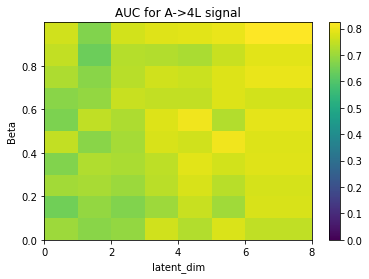

In [31]:
A1=[[0.5554301485452765, (0.001, 1)], [0.589192494847674, (0.001, 2)], [0.5296286549745054, (0.001, 3)], [0.718704921510523, (0.001, 4)], [0.7348851557562308, (0.001, 5)], [0.7258598855331312, (0.001, 6)], [0.7275167686976378, (0.001, 8)], [0.7041372365633009, (0.1, 1)], [0.6782597027035255, (0.1, 2)], [0.6900381211955906, (0.1, 3)], [0.7631537826469372, (0.1, 4)], [0.7289502860631434, (0.1, 5)], [0.7757852330613361, (0.1, 6)], [0.7430489356928506, (0.1, 8)], [0.6443775207252544, (0.2, 1)], [0.6902907500123509, (0.2, 2)], [0.6684210297022842, (0.2, 3)], [0.7013941859637055, (0.2, 4)], [0.7549105730276581, (0.2, 5)], [0.7051126879823586, (0.2, 6)], [0.7733408549988628, (0.2, 8)], [0.7095036374862058, (0.3, 1)], [0.7158555424698233, (0.3, 2)], [0.6999294489271481, (0.3, 3)], [0.7367036707368074, (0.3, 4)], [0.7727896568241156, (0.3, 5)], [0.7353622886221604, (0.3, 6)], [0.7702464503754044, (0.3, 8)], [0.6684161170187343, (0.4, 1)], [0.7259188385345189, (0.4, 2)], [0.7174269324177309, (0.4, 3)], [0.7404695299437768, (0.4, 4)], [0.7859993708171099, (0.4, 5)], [0.7656397176483989, (0.4, 6)], [0.7828640188127433, (0.4, 8)]]

A2=[[0.7460942934038065, (0.5, 1)], [0.6772851520756619, (0.5, 2)], [0.7125900238002828, (0.5, 3)], [0.773459291474385, (0.5, 4)], [0.7636956418652117, (0.5, 5)], [0.8060024195768692, (0.5, 6)], [0.7807853624561573, (0.5, 8)], [0.6615002488225481, (0.6, 1)], [0.7455604368817251, (0.6, 2)], [0.7215340156556707, (0.6, 3)], [0.7810597645223966, (0.6, 4)], [0.8045724961767546, (0.6, 5)], [0.7296303330216654, (0.6, 6)], [0.7898853413619209, (0.6, 8)], [0.6770894012215265, (0.7, 1)], [0.6908585065633766, (0.7, 2)], [0.7525662755202757, (0.7, 3)], [0.7462579576385863, (0.7, 4)], [0.746212697612765, (0.7, 5)], [0.7787000756619614, (0.7, 6)], [0.7671651612248837, (0.7, 8)], [0.7219211899453136, (0.8, 1)], [0.6776122009250328, (0.8, 2)], [0.7360554334870885, (0.8, 3)], [0.7624860515367308, (0.8, 4)], [0.7581328137136184, (0.8, 5)], [0.7786117451346471, (0.8, 6)], [0.7962583393508461, (0.8, 8)], [0.7469817979320864, (0.9, 1)], [0.6368131751500672, (0.9, 2)], [0.7299775461248937, (0.9, 3)], [0.7296760525818938, (0.9, 4)], [0.7181744279127296, (0.9, 5)], [0.7537051564030773, (0.9, 6)], [0.7877712263997314, (0.9, 8)], [0.7623138812587671, (0.999, 1)], [0.6683108380304459, (0.999, 2)], [0.7668544108390826, (0.999, 3)], [0.7835597033184154, (0.999, 4)], [0.7851226024398725, (0.999, 5)], [0.794631193083219, (0.999, 6)], [0.8231558219568053, (0.999, 8)]]
AUC=[]
s=[]
b=[]

A=np.array

for i in range(0,len(A1)):
    AUC+=[A1[i][0]]
    b+=[A1[i][1][0]]
    s+=[A1[i][1][1]]

for j in range(0,len(A2)):
    AUC+=[A2[j][0]]
    b+=[A2[j][1][0]]
    s+=[A2[j][1][1]]

plt.hist2d(s,b,weights=AUC,bins=[[0,1+0.0001,2+0.0001,3+0.0001,4+0.0001,5+0.0001,6+0.0001,8+0.0001],[0,0.001+0.0001,0.1+0.0001,0.2+0.0001,0.3+0.0001,0.4+0.0001,0.5+0.0001,0.6+0.0001,0.6+0.0001,0.7+0.0001,0.8+0.0001,0.9+0.0001,0.999+0.0001]])
plt.xlabel('latent_dim')
plt.ylabel('Beta')
plt.colorbar()
plt.title('AUC for A->4L signal')
plt.show()

In [6]:
beta_list=[0.001,0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999]
Trad_sens=[]
Trad_AUC=[]
new_metric=[]


Losses=['CKL']
for beta in beta_list:
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/Miscellaneous Studies/Signal_Independant_Efficiency_Study/Models_for_Study/beta_value_{}/'.format(beta),Data_Test_Flat,signals,title='Beta {} Loss'.format(beta), save=False,labels=sig_label,latent_dim=3)
    a=evaluation.calculate_loss('CKL')
    t_sens=evaluation.S_F(1,10**-5)
    Trad_sens+=[t_sens]
    Trad_AUC+=[evaluation.AUC()]
    new_metric+=[evaluation.backround_density(10**-5)]

10642/10642 [==============================] - 16s 1ms/step
208714.67
10642/10642 [==============================] - 16s 2ms/step
50588.953
10642/10642 [==============================] - 16s 2ms/step
39529.55
10642/10642 [==============================] - 16s 2ms/step
25805.492
10642/10642 [==============================] - 16s 1ms/step
15655.102
10642/10642 [==============================] - 16s 1ms/step
4755.1714
10642/10642 [==============================] - 16s 2ms/step
2812.334
10642/10642 [==============================] - 16s 1ms/step
16834.484
10642/10642 [==============================] - 16s 2ms/step
2915.4666
10642/10642 [==============================] - 16s 1ms/step
12342.614
10642/10642 [==============================] - 16s 2ms/step
4872.2515
10642/10642 [==============================] - 16s 2ms/step
672.5595
10642/10642 [==============================] - 16s 2ms/step
390.73288


In [4]:
latent_sizes=[3,4,5,6,7,8]
Trad_sens2=[]
Trad_AUC2=[]
new_metric2=[]


Losses=['CKL']
for size in latent_sizes:
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/Miscellaneous Studies/Signal_Independant_Efficiency_Study/Models_for_Study/Latent_space_{}/'.format(size),Data_Test_Flat,signals,title='Latent Size {} Loss'.format(size), save=False,labels=sig_label,latent_dim=size)
    a=evaluation.calculate_loss('CKL')
    t_sens=evaluation.S_F(1,10**-5)
    Trad_sens2+=[t_sens]
    Trad_AUC2+=[evaluation.AUC()]
    new_metric2+=[evaluation.backround_density(10**-5)]

10642/10642 [==============================] - 16s 1ms/step
770.48804
10642/10642 [==============================] - 17s 2ms/step
701.64215
10642/10642 [==============================] - 16s 2ms/step
485.7072
10642/10642 [==============================] - 16s 2ms/step
531.3642
10642/10642 [==============================] - 16s 1ms/step
397.43472
10642/10642 [==============================] - 16s 2ms/step
442.24014


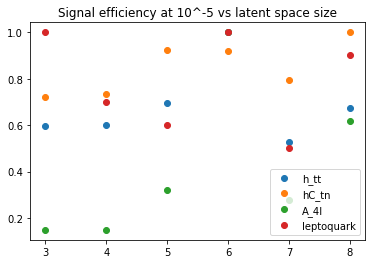

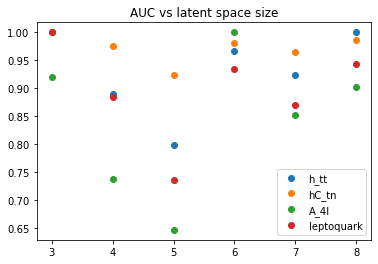

In [5]:
Trad_sens2=np.array(Trad_sens2)
s12=Trad_sens2[:,0]
s22=Trad_sens2[:,1]
s32=Trad_sens2[:,2]
s42=Trad_sens2[:,3]
x2=latent_sizes
plt.plot(x2,s12/np.max(s12),'o',label='h_tt')
plt.plot(x2,s22/np.max(s22),'o',label='hC_tn')
plt.plot(x2,s32/np.max(s32),'o',label='A_4l')
plt.plot(x2,s42/np.max(s42),'o',label='leptoquark')
plt.title('Signal efficiency at 10^-5 vs latent space size')
#plt.plot(x2,new_metric2/np.max(new_metric2),'o',label='latent number density')
plt.legend()
plt.show()

Trad_AUC2=np.array(Trad_AUC2)
A12=Trad_AUC2[:,0]
A22=Trad_AUC2[:,1]
A32=Trad_AUC2[:,2]
A42=Trad_AUC2[:,3]
plt.plot(x2,A12/np.max(A12),'o',label='h_tt')
plt.plot(x2,A22/np.max(A22),'o',label='hC_tn')
plt.plot(x2,A32/np.max(A32),'o',label='A_4l')
plt.plot(x2,A42/np.max(A42),'o',label='leptoquark')
plt.title('AUC vs latent space size')
#plt.plot(x2,new_metric2/np.max(new_metric2),'o',label='latent number density')
plt.legend()
plt.show()

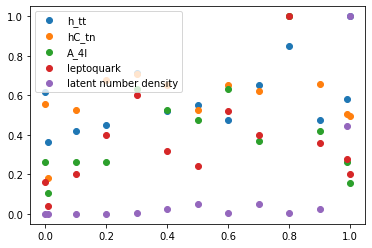

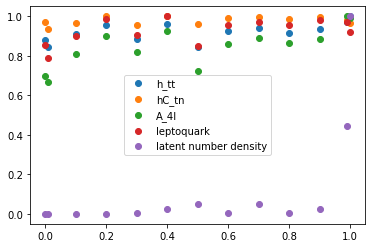

In [10]:
Trad_sens=np.array(Trad_sens)
s1=Trad_sens[:,0]
s2=Trad_sens[:,1]
s3=Trad_sens[:,2]
s4=Trad_sens[:,3]
x=beta_list
plt.plot(x,s1/np.max(s1),'o',label='h_tt')
plt.plot(x,s2/np.max(s2),'o',label='hC_tn')
plt.plot(x,s3/np.max(s3),'o',label='A_4l')
plt.plot(x,s4/np.max(s4),'o',label='leptoquark')
plt.plot(x,new_metric/np.max(new_metric),'o',label='latent number density')
plt.legend()
plt.show()

Trad_AUC=np.array(Trad_AUC)
A1=Trad_AUC[:,0]
A2=Trad_AUC[:,1]
A3=Trad_AUC[:,2]
A4=Trad_AUC[:,3]
plt.plot(x,A1/np.max(A1),'o',label='h_tt')
plt.plot(x,A2/np.max(A2),'o',label='hC_tn')
plt.plot(x,A3/np.max(A3),'o',label='A_4l')
plt.plot(x,A4/np.max(A4),'o',label='leptoquark')
plt.plot(x,new_metric/np.max(new_metric),'o',label='latent number density')
plt.legend()
plt.show()

#plt.plot(latent_sizes,new_metric,'o',label='latent number density')